In [ ]:
from music21 import converter, instrument, note, chord, stream, midi
from google.colab import files
import glob
import os
import gzip
import tarfile    
from torchvision import datasets                  
import numpy as np
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

assert torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Import Drive for easier saving
from google.colab import drive
drive.mount('/content/drive')

def force_remount():
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def download_data(filepath):
    if not os.path.exists(os.path.join(filepath, 'mozart_sonatas.tar.gz')):
      datasets.utils.download_url('https://github.com/Foundations-of-Applied-Mathematics/Data/raw/master/RNN/mozart_sonatas.tar.gz', filepath, 'mozart_sonatas.tar.gz', None)

    print('Extracting {}'.format('mozart_sonatas.tar.gz'))
    gzip_path = os.path.join(filepath, 'mozart_sonatas.tar.gz')
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())

    print('Untarring {}'.format('mozart_sonatas.tar'))
    tar_path = os.path.join(filepath,'mozart_sonatas.tar')
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

    return

**Problem 1**:

Download the data.
Write a function that accepts the path to the .mid files, parses the files, and returns a list of the $119348$ pitches as strings. 
For the Chords, join the pitches of the notes in the chords with a . as in D3.D2.

Print the length of your list and the number of unique pitches.


In [ ]:
# Download Data
download_data("drive/MyDrive/Colab")

Extracting mozart_sonatas.tar.gz
Untarring mozart_sonatas.tar


In [ ]:
def parse_midi(path_to_dir):
    """
    This function takes in the path to a directory, iterates through all the 
    midi files in that directory and uses the converter to parse
    through the files and chords. 
    """

    notes = []
    # iterate through file names
    for filename in os.listdir(path_to_dir):
        # get full file path
        file_path = "".join((path_to_dir, filename))

        # check to make sure it ias a file
        if not os.path.isfile(file_path):
            continue

        # check that it is a midi file
        name, extension = os.path.splitext(file_path)
        if not extension == ".mid":
            continue

        # get converter
        midi = converter.parse(file_path)
        # parse through notes
        notes_to_parse = instrument.partitionByInstrument(midi).parts[0].recurse()

        for element in notes_to_parse:
            # if the element is a note
            if isinstance(element, note.Note):
                #add pitch
                notes.append(str(element.pitch))
            # if element is a chord
            elif isinstance(element, chord.Chord):
                pitch_vals = []
                for p in element.pitches:
                    pitch_vals.append(str(p))
                # joint pitches and append them
                notes.append(".".join(pitch_vals))
    return notes

all_pitches = parse_midi("drive/MyDrive/Colab/mozart_sonatas/mozart_sonatas/")
unique_pitches = list(set(all_pitches))
print('Length of list:', len(all_pitches), sep=" ")
print('Number of unique pitches:', len(unique_pitches), sep=" ")

loss:4.2541: 100%|██████████| 745/745 [11:33<00:00,  1.07it/s]


Length of list: 119348
Number of unique pitches: 741


**Problem 2.** 

Using the list returned in Problem 1, create the training and testing DataLoaders.
Make sure to do all of the following steps:


1) Convert the pitches to integers.
2) Split the data into Long tensors of length 100.
3) Create the labels.
4) Randomly split the data into training and test sets using an 80/20 split.
5) Create the DataLoaders for both sets of data, using batch_size=128 for the training data and batch_size=1 for the test data.
 

Print the length of each DataLoader.


In [ ]:
def create_data_loader(pitches, unique_pitches, shuffle=True):

    # number of pitches
    N = len(pitches)
    # get dictionary where key is the pitch and i is the index it is mapped to
    index_map = {p : i for i, p in enumerate(unique_pitches)}
    pitch_map = {i : p for i, p in enumerate(unique_pitches)}
    # relable pitches by indices using index map
    pitch_ints = [index_map[p] for p in pitches]

    # initialize data points 
    data_points = []

    # loop counter
    i = 0
    # if i < N - 100 then we can create a new sequence
    while i < N - 100:
        # create currrent sequence
        sequence = torch.LongTensor(pitch_ints[i:i+100])
        # get label
        label = pitch_ints[i+100]

        # create current data point
        data_point = [sequence, label]
        # append to list of datapoints
        data_points.append(data_point)

        i += 1

    # get number of training and testing points
    N = len(data_points)
    training_size = int(N*0.8)
    testing_size = N - training_size

    # get random split on data set 
    train_data, test_data = random_split(data_points, [training_size, testing_size], generator=torch.Generator().manual_seed(42))

    # create train and test dataloaders
    train_loader = DataLoader(train_data, batch_size=128, shuffle=shuffle, drop_last=True)
    test_loader = DataLoader(test_data, batch_size=1, shuffle=shuffle)

    return train_loader, test_loader, data_points, index_map, pitch_map

train_loader, test_loader, data_points, index_map, pitch_map = create_data_loader(all_pitches, unique_pitches)

**Problem 3**

Create the network class.
Include at least $3$ LSTM layers, each followed by Dropout layers with probability $.3.$
Also have at least $2$ Linear layers.
The last LSTM layer and each of the Linear layers should be followed by a BatchNorm1d layer, for at least $3$ total batchnorm layers.
The final layer should be a Softmax activation.

Initialize the model, loss as CrossEntropyLoss, and optimizer as RMSprop.

Train the model until the accuracy is above 95\%. This can take?



After taking a backwards step during training, scale the gradients using 
nn.utils.clip_grad_norm_(model.parameters(), 5)
This will ensure that the gradients are reasonably sized so that the model can learn.

At the end of each epoch, calculate the accuracy and mean loss on the test data.
Remember to change the model to eval() mode when running the test data and train() when running on the training data.

After the accuracy is above 95\%, plot the training and test losses versus epochs on the same plot.
Plot the accuracy versus epochs.


In [ ]:
class Network(nn.Module):
    """ 
    Example class for LSTM model 
    """
    def __init__(self,n_notes,embedding_dim):
        super(Network, self).__init__()
        self.hidden_size = 512
        self.num_layers = 3
        self.dropout = 0.3
        self.n_notes = n_notes
        self.embedding = nn.Embedding(n_notes, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, self.hidden_size, self.num_layers, batch_first=True, dropout=.3)

        self.batch1 = nn.BatchNorm1d(self.hidden_size)
        self.batch2 = nn.BatchNorm1d(3*self.n_notes)
        self.batch3 = nn.BatchNorm1d(self.n_notes)

        self.dropout = nn.Dropout(.3)

        self.linear1 = nn.Linear(in_features = self.hidden_size, out_features=3 *self.n_notes)

        self.linear2 = nn.Linear(in_features = 3*self.n_notes, out_features=self.n_notes)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x, hidden):
        # embed data
        embeds = self.embedding(x)
        # get lstm and new hidden layers
        lstm_out, hidden = self.lstm(embeds, hidden)
        # get output after 1st batch norm and 1st dropout layer
        out = self.dropout(self.batch1(lstm_out[:,-1])) #output from final step is passed forward

        # now, apply first linear layer, and second batch norm batch
        out = self.batch2(self.linear1(out))

        # now apply second linear layer, and third batch norm
        out = self.batch3(self.linear2(out))

        return self.softmax(out), hidden

    def initHidden(self, batch_size):
        weight = next(self.parameters()).data
        h0 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        h1 = weight.new(self.num_layers, batch_size, self.hidden_size).zero_().to(device)
        return (h0, h1)

In [ ]:
def train_model(train_loader, test_loader):

    # initalize model
    N1 = len(train_loader.dataset)
    N2 = len(test_loader.dataset) 
    model = Network(741, 64)
    model = model.to(device)
    # initial objective function as cross entropy loss
    objective = nn.CrossEntropyLoss()
    # initialize optimizer 
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)

    mean_loss_train = []
    accuracy_train = []
    mean_loss_test = []
    accuracy_test = []
    # train for 35 epochs
    for epoch in range(35):
        # initalize hidden states
        filepath = "drive/MyDrive/Colab/epoch{}.pt".format(epoch)
        # set to train mode
        model.train()
        # loop counter
        loop = tqdm(total=len(train_loader), position=0)
        # all the loss values inside the given epoch
        epoch_loss = []
        epoch_accuracy = 0

        # iterate over train set
        for batch, (x, y_truth) in enumerate(train_loader):
            (h0, h1) = model.initHidden(128)
            # get x and labels
            x, y_truth = x.to(device), y_truth.to(device)

            # zero out gradients
            optimizer.zero_grad()

            # run the model
            outputs, (h0, h1) = model.forward(x, (h0, h1))

            # calculate accuracy
            epoch_accuracy += torch.sum(outputs.argmax(1) == y_truth)

            h0 = h0.detach()
            h1 = h1.detach()

            # calculate the loss  and append it to the epoch loss
            loss = objective(outputs, y_truth)
            epoch_loss.append(loss.item())
            # compute the gradients
            loss.backward() 
            # scale gradients
            nn.utils.clip_grad_norm_(model.parameters(), 5)
            # optimize and update the weights 
            optimizer.step()

            # update loop
            loop.set_description("loss:{:.4f}".format(loss.item()))
            loop.update()

        # calculate mean loss for the epoch
        mean_loss_train.append(np.mean(epoch_loss))
        # calculate training accuracy for the epoch
        accuracy_train.append(epoch_accuracy / N1)

        # save weights every epoch
        torch.save({
            "epoch": epoch, 
            "model_state_dict":model.state_dict(),
            "optimizer_state_dict":optimizer.state_dict(),
            "loss": mean_loss_train[epoch]}, 
            filepath)

        # now we calculate the accuracy and loss for test set
        # set to eval mode
        model.eval()
        # instantiate lists
        epoch_loss = []
        epoch_accuracy = 0
        for batch, (x, y_truth) in enumerate(test_loader):
            x, y_truth = x.to(device), y_truth.to(device)

            # initalize hidden states
            (h0, h1) = model.initHidden(1)
            # calculate output
            out, (h0, h1) = model.forward(x, (h0, h1))
            # calculate test loss
            loss = objective(out, y_truth)
            epoch_loss.append(loss.item())
            # if output matches truth increment accuracy
            epoch_accuracy += torch.sum(out.argmax() == y_truth)

            h0 = h0.detach()
            h1 = h1.detach()

        # calculate test accuracy
        accuracy_test.append(epoch_accuracy / N2)
        # calculate test loss
        mean_loss_test.append(np.mean(epoch_loss))

    return model, accuracy_train, mean_loss_train, accuracy_test, mean_loss_test, objective, optimizer

model, accuracy_train, mean_loss_train, accuracy_test, mean_loss_test, objective, optimizer = train_model(train_loader, test_loader)

loss:0.6922: 100%|██████████| 745/745 [05:29<00:00,  2.26it/s]


Text(0.5, 1.0, 'Epoch vs. Accuracy')

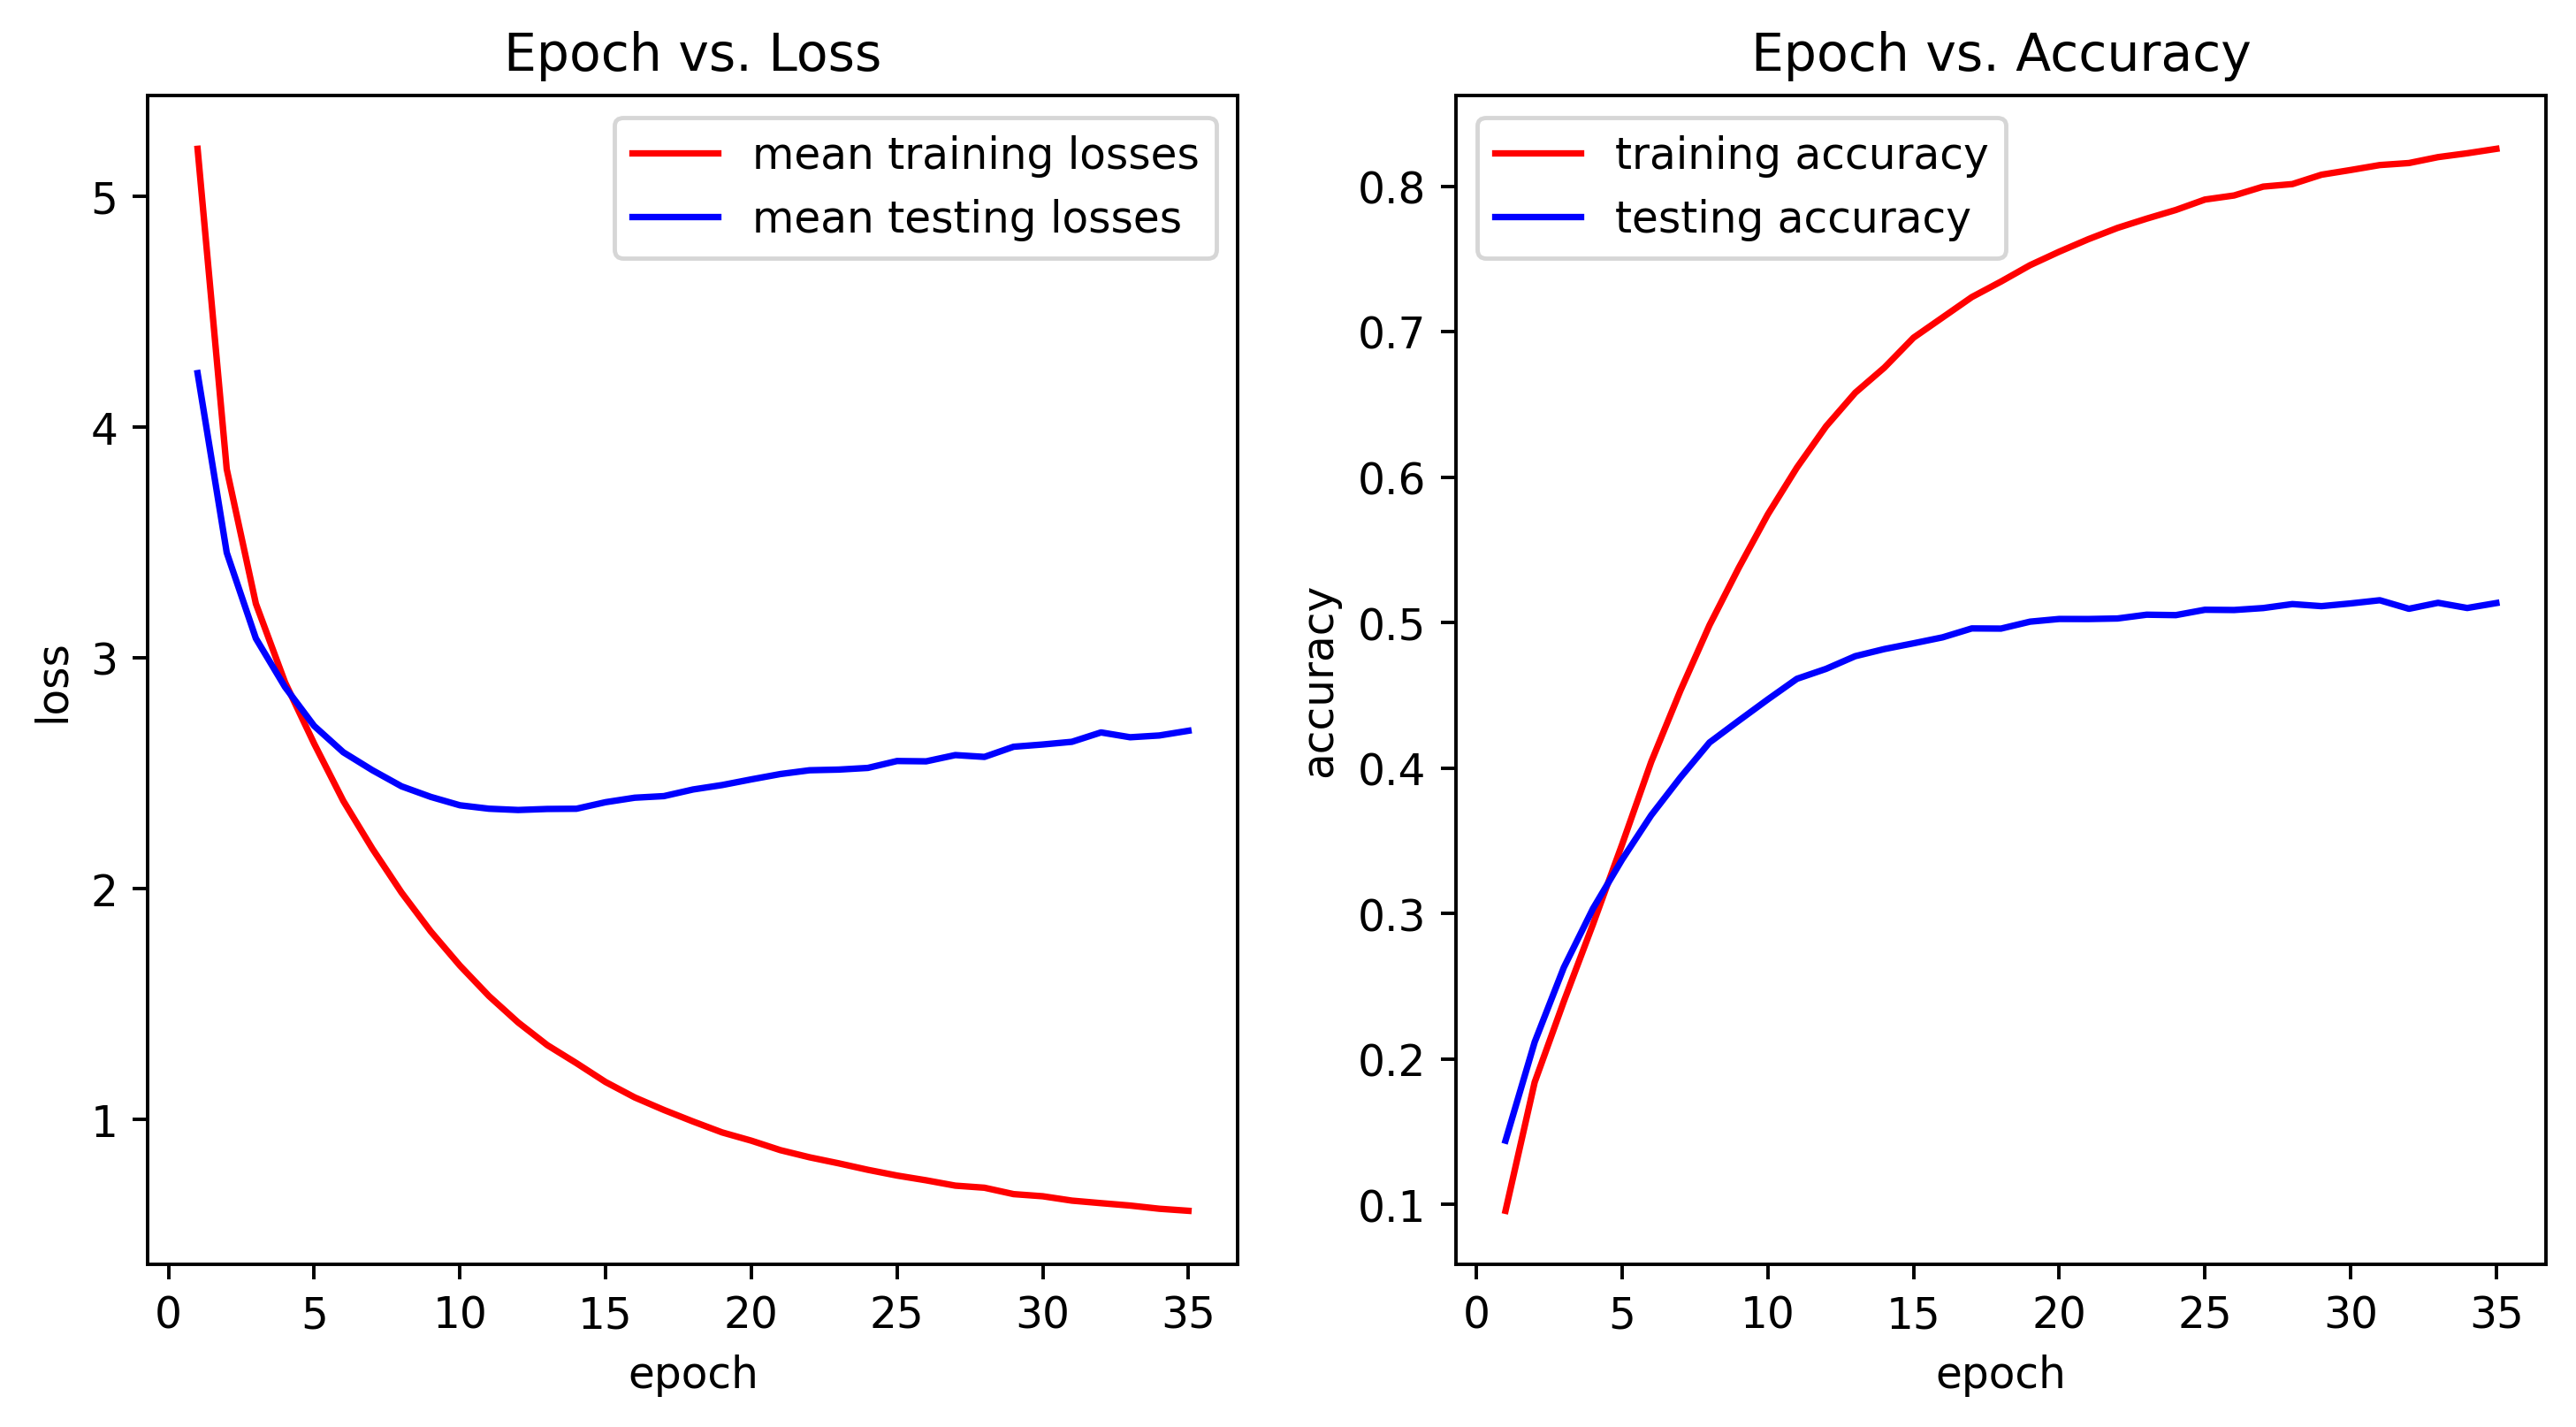

In [ ]:
# now we plot

epochs = np.arange(35) + 1
fig = plt.figure(figsize=(10, 5))
fig.set_dpi(175)

ax = fig.add_subplot(121)
ax.plot(epochs, mean_loss_train, 'r-', label="mean training losses")
ax.plot(epochs, mean_loss_test, 'b-', label="mean testing losses")
ax.legend(loc='best')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.set_title('Epoch vs. Loss')

ax = fig.add_subplot(122)
accuracy_train = [a.cpu() for a in accuracy_train]
accuracy_test = [a.cpu() for a in accuracy_test]
ax.plot(epochs, accuracy_train, 'r-', label="training accuracy")
ax.plot(epochs, accuracy_test, 'b-', label="testing accuracy")
ax.legend(loc='best')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.set_title('Epoch vs. Accuracy')

In [ ]:
# save model via pickle
import pickle

with open("drive/MyDrive/Colab/model.obj", "wb") as out:
    pickle.dump(model, out)

with open("drive/MyDrive/Colab/accuracy_train.obj", "wb") as out:
    pickle.dump(accuracy_train, out)

with open("drive/MyDrive/Colab/mean_loss_train.obj", "wb") as out:
    pickle.dump(mean_loss_test, out)

with open("drive/MyDrive/Colab/accuracy_test.obj", "wb") as out:
    pickle.dump(accuracy_test, out)

with open("drive/MyDrive/Colab/mean_loss_test.obj", "wb") as out:
    pickle.dump(mean_loss_test, out)

with open("drive/MyDrive/Colab/objective.obj", "wb") as out:
    pickle.dump(objective, out)

with open("drive/MyDrive/Colab/optimizer.obj", "wb") as out:
    pickle.dump(optimizer, out)


**Problem 4.** 
Write a function that randomly chooses a sequence in the test data and predicts
the next 500 elements. 
Return a list of the 600 pitches in the sequence.

In [ ]:
def load_model(filename):
    """ 
    Load a saved model to continue training or evaluate 
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Network(741, 64)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

    checkpoint = torch.load(filename,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model.eval() # For evaluation only
  
    return model, criterion, optimizer

def load_train(filename):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = Network(741, 64)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.RMSprop(model.parameters(),lr=.001)

    checkpoint = torch.load(filename,map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    last_epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return

In [ ]:
def predict_pitches(model, test_loader):
    

    return

pitches = predict_pitches()

**Problem 5.** 
Convert the sequence from Problem 4 into note and chord objects and save it to
'mozart.mid'.